In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

In [31]:
data1 = pd.read_json('D:\Sarcasm_Headlines_Dataset.json', lines=True)
data2 = pd.read_json('D:\Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = pd.concat([data1, data2], ignore_index=True)
df.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


Text(0.5, 1.0, 'Countplot of headlines')

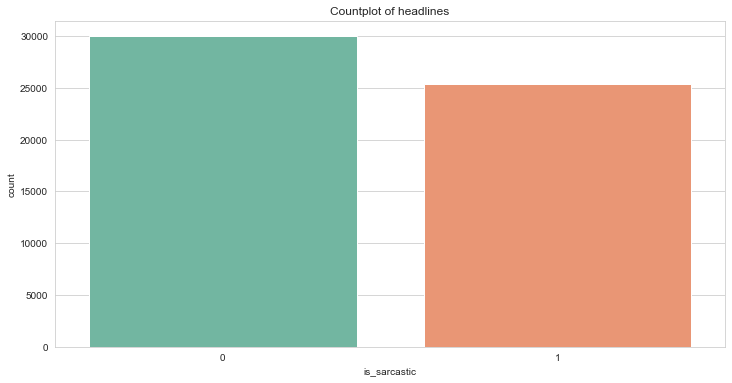

In [3]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [4]:
# Add new column 'headline_len': Text length of headline 
df['headline_len'] = df['headline'].map(len)

In [5]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
  return link.split('//')[1].split('.com')[0].replace('www.', "")

In [6]:
# Apply extract_website func to df article_link and create new column with website name
df['website'] = df['article_link'].apply((lambda x: extract_website(x)))

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'huffingtonpost'),
  Text(1, 0, 'local.theonion'),
  Text(2, 0, 'politics.theonion'),
  Text(3, 0, 'entertainment.theonion'),
  Text(4, 0, 'theonion'),
  Text(5, 0, 'sports.theonion'),
  Text(6, 0, 'ogn.theonion')])

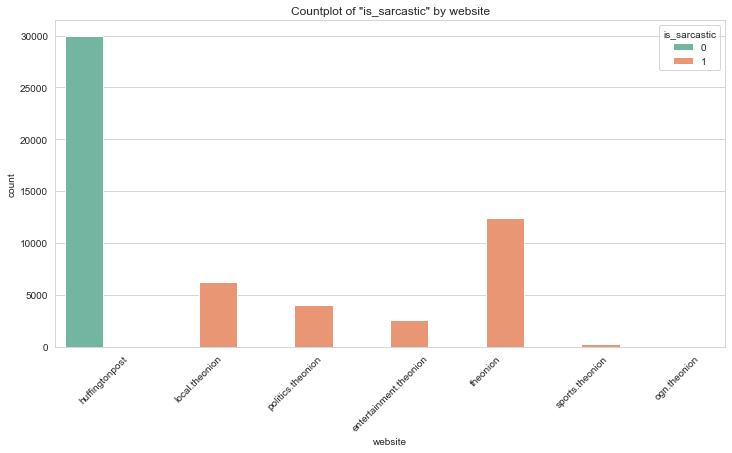

In [7]:
# Check number of headlines by is_sarcastic for every website
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'website', hue='is_sarcastic', palette="Set2").set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=45)

In [8]:
# Sort dataframe by headline length. Check the longest headline.
df.sort_values(by='headline_len', ascending=False).head(4)

,article_link,headline,is_sarcastic,headline_len,website
34011,https://www.theonion.com/hot-wheels-ranked-num...,hot wheels ranked number one toy for rolling d...,1,926,theonion
28855,https://www.theonion.com/maya-angelou-poet-aut...,"maya angelou, poet, author, civil rights activ...",1,254,theonion
19868,https://www.theonion.com/maya-angelou-poet-aut...,"maya angelou, poet, author, civil rights activ...",1,254,theonion
43297,https://entertainment.theonion.com/12-years-a-...,"'12 years a slave,' 'captain phillips,' 'ameri...",1,238,entertainment.theonion


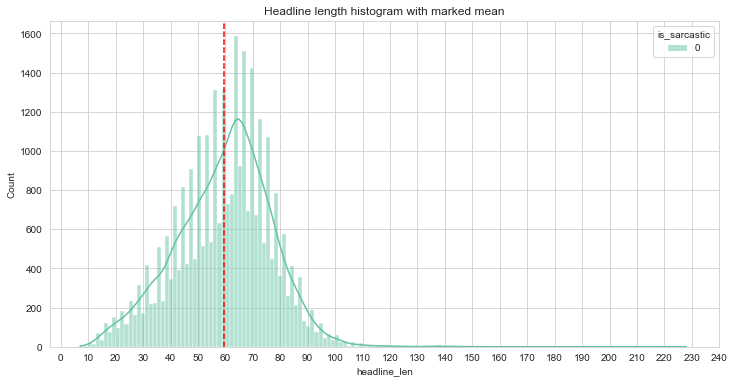

In [9]:
# Histogram of headline length for not "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 0
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

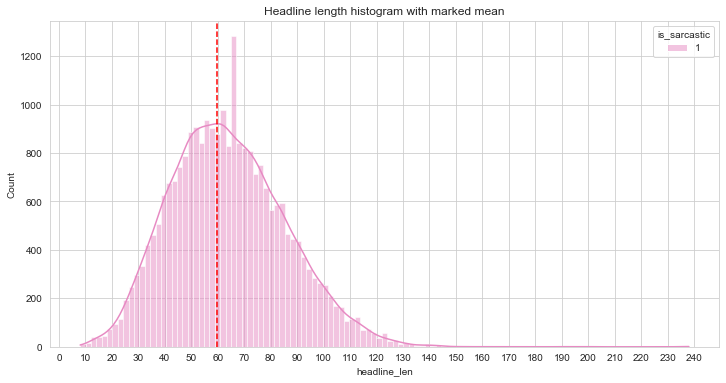

In [10]:
# Histogram of headline length for "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 1)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2_r').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 1
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

In [11]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [12]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [13]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [14]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
training_portion = .7 # train test split 70:30

In [15]:
# Set the train size using training_portion arg
train_size = int(len(sentences) * training_portion)

# Split
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Check
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

38729
38729
38729
16599
16599


In [16]:
# Tokenizing and padding
# For Train
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [17]:
# Prepare labels for model: Train
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(38729,)
(16599,)


In [18]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
# MODEL
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 40)                8040      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                        

In [21]:
# Set callback functions to early stop training and save the best model so far
filepath='best_model.h5'
overfitCallback = [EarlyStopping(monitor='val_loss', patience=5),
         ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)]

In [22]:
# Fit the model
num_epochs = 30
#history = model.fit(train_padded, training_labels_final, epochs=num_epochs, callbacks=[overfitCallback], validation_data=(validation_padded, validation_labels_final))
history = model.fit(train_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/30
1211/1211 [==============================] - 40s 32ms/step - loss: 0.5755 - accuracy: 0.7034 - val_loss: 0.3873 - val_accuracy: 0.8648
Epoch 2/30
1211/1211 [==============================] - 39s 32ms/step - loss: 0.3724 - accuracy: 0.8605 - val_loss: 0.2608 - val_accuracy: 0.9133
Epoch 3/30
1211/1211 [==============================] - 37s 30ms/step - loss: 0.2509 - accuracy: 0.9190 - val_loss: 0.2151 - val_accuracy: 0.9369
Epoch 4/30
1211/1211 [==============================] - 43s 35ms/step - loss: 0.1782 - accuracy: 0.9474 - val_loss: 0.2165 - val_accuracy: 0.9520
Epoch 5/30
1211/1211 [==============================] - 44s 37ms/step - loss: 0.1370 - accuracy: 0.9619 - val_loss: 0.2102 - val_accuracy: 0.9592
Epoch 6/30
1211/1211 [==============================] - 47s 39ms/step - loss: 0.1151 - accuracy: 0.9689 - val_loss: 0.2922 - val_accuracy: 0.9598
Epoch 7/30
1211/1211 [==============================] - 50s 41ms/step - loss: 0.1048 - accuracy: 0.9726 - val_loss: 0.2017 -

In [134]:
# evaluate the model
_, train_acc = model.evaluate(train_padded, training_labels_final)
_, test_acc = model.evaluate(validation_padded, validation_labels_final)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

519/519 [==============================] - 1s 2ms/step - loss: 0.6106 - accuracy: 0.9866
Train: 0.999, Test: 0.987


In [155]:
print(train_acc, test_acc)

0.9989413619041443 0.9866256713867188


In [124]:
best = {
  "loss": history.history['loss'][27],
  "accuracy": history.history['accuracy'][27],
  "val_loss": history.history['val_loss'][27],
  "val_accuracy": history.history['val_accuracy'][27]
}

best

{'loss': 0.024681758135557175,
 'accuracy': 0.9947842955589294,
 'val_loss': 0.3780992925167084,
 'val_accuracy': 0.9874691367149353}

In [24]:
# predict probabilities for test set
yhat_probs = model.predict(validation_padded, verbose=0)
#yhat_classes = model.predict_classes(validation_padded, verbose=0)

In [25]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(validation_labels_final, yhat_probs.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(validation_labels_final, yhat_probs.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(validation_labels_final, yhat_probs.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(validation_labels_final, yhat_probs.round())
print('F1 score: %f' % f1)

Accuracy: 0.986626
Precision: 0.996365
Recall: 0.975346
F1 score: 0.985744


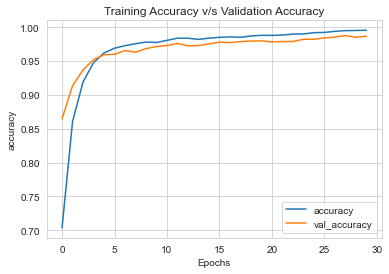

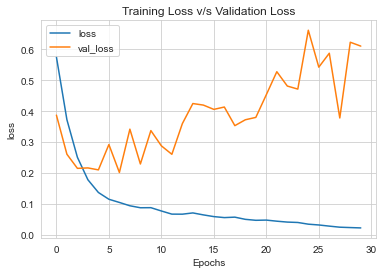

In [41]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string, string2):
  plt.title(string)
  plt.plot(history.history[string2])
  plt.plot(history.history['val_'+string2])
  plt.xlabel("Epochs")
  plt.ylabel(string2)
  plt.legend([string2, 'val_'+string2])
  plt.show()

plot_graphs(history, "Training Accuracy v/s Validation Accuracy", "accuracy")
print("")
plot_graphs(history, "Training Loss v/s Validation Loss", "loss")

In [28]:
# Print Confusion matrix
print(classification_report(validation_labels, yhat_probs.round(), target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.98      1.00      0.99      8730
    Sarcastic       1.00      0.98      0.99      7869

     accuracy                           0.99     16599
    macro avg       0.99      0.99      0.99     16599
 weighted avg       0.99      0.99      0.99     16599



In [3]:
datafile1 = pd.read_json('D:\Sarcasm_Headlines_Dataset.json', lines=True)
datafile2 = pd.read_json('D:\Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [4]:
datafile1=datafile1.drop(['article_link'],axis=1)
datafile2=datafile2.drop(['article_link'],axis=1)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
x = datafile1.headline.values
y = datafile1.is_sarcastic.values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.5)

In [24]:
Y_train.shape

(13354,)

In [28]:
type(x)

numpy.ndarray

In [33]:
BernNB = make_pipeline(TfidfVectorizer(), BernoulliNB())
BernNB.fit(X_train,Y_train)
Y_bexpect = Y_test
Y_bprid = BernNB.predict(X_test)

b_accuracy = accuracy_score(Y_test, Y_bprid)
print('Accuracy: %f' % b_accuracy)

b_precision = precision_score(Y_test, Y_bprid)
print('Precision: %f' % b_precision)

b_recall = recall_score(Y_test, Y_bprid)
print('Recall: %f' % b_recall)

b_f1 = f1_score(Y_test, Y_bprid)
print('F1 score: %f' % b_f1)

Accuracy: 0.834219
Precision: 0.868523
Recall: 0.731724
F1 score: 0.794276


In [34]:
MultiNB = make_pipeline(TfidfVectorizer(), MultinomialNB())
MultiNB.fit(X_train,Y_train)
Y_mexpect = Y_test
Y_mprid = MultiNB.predict(X_test)

m_accuracy = accuracy_score(Y_test, Y_mprid)
print('Accuracy: %f' % m_accuracy)

m_precision = precision_score(Y_test, Y_mprid)
print('Precision: %f' % m_precision)

m_recall = recall_score(Y_test, Y_mprid)
print('Recall: %f' % m_recall)

m_f1 = f1_score(Y_test, Y_mprid)
print('F1 score: %f' % m_f1)

Accuracy: 0.811681
Precision: 0.893330
Recall: 0.646636
F1 score: 0.750223


In [35]:
svm = make_pipeline(TfidfVectorizer(), SVC())
svm.fit(X_train,Y_train)
Y_sexpect = Y_test
Y_spred = svm.predict(X_test)

s_accuracy = accuracy_score(Y_test, Y_spred)
print('Accuracy: %f' % s_accuracy)

s_precision = precision_score(Y_test, Y_spred)
print('Precision: %f' % s_precision)

s_recall = recall_score(Y_test, Y_spred)
print('Recall: %f' % s_recall)

s_f1 = f1_score(Y_test, Y_spred)
print('F1 score: %f' % s_f1)

Accuracy: 0.841707
Precision: 0.824143
Recall: 0.811162
F1 score: 0.817601


In [36]:
Dtree = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
Dtree.fit(X_train,Y_train)
Y_dexpect = Y_test
Y_dpred = Dtree.predict(X_test)

d_accuracy = accuracy_score(Y_test, Y_dpred)
print('Accuracy: %f' % d_accuracy)

d_precision = precision_score(Y_test, Y_dpred)
print('Precision: %f' % d_precision)

d_recall = recall_score(Y_test, Y_dpred)
print('Recall: %f' % d_recall)

d_f1 = f1_score(Y_test, Y_dpred)
print('F1 score: %f' % d_f1)

Accuracy: 0.747435
Precision: 0.713569
Recall: 0.705872
F1 score: 0.709700


In [37]:
RF = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
RF.fit(X_train, Y_train)
Y_rexpect = Y_test
Y_rpred = RF.predict(X_test)

r_accuracy = accuracy_score(Y_test, Y_rpred)
print('Accuracy: %f' % r_accuracy)

r_precision = precision_score(Y_test, Y_rpred)
print('Precision: %f' % r_precision)

r_recall = recall_score(Y_test, Y_rpred)
print('Recall: %f' % r_recall)

r_f1 = f1_score(Y_test, Y_rpred)
print('F1 score: %f' % r_f1)

Accuracy: 0.803370
Precision: 0.774927
Recall: 0.775723
F1 score: 0.775325


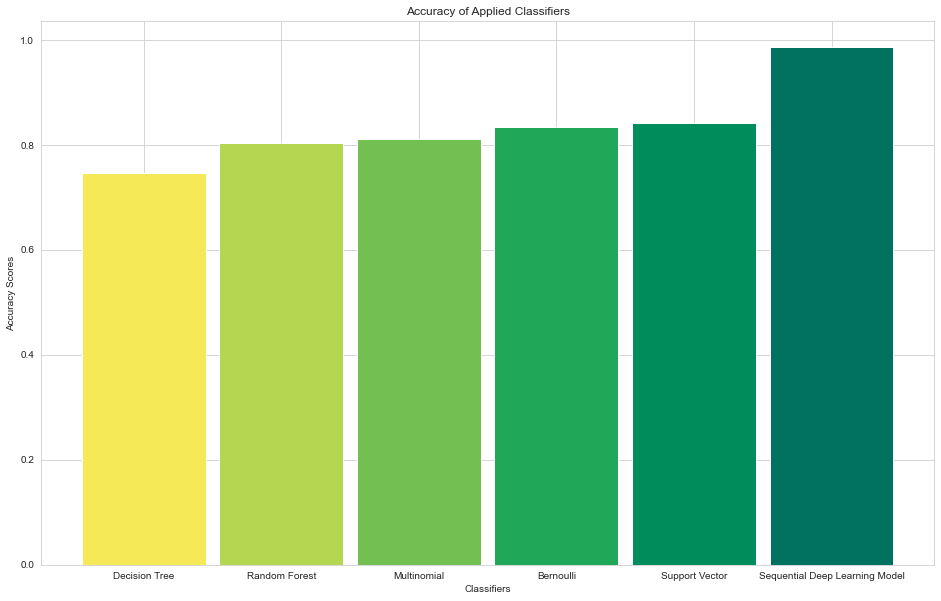

In [38]:
# x-coordinates of left sides of bars
left = [1, 2, 3, 4, 5, 6]
 
plt.figure(figsize=(16,10))
# heights of bars
height = [d_accuracy, r_accuracy, m_accuracy, b_accuracy, s_accuracy, accuracy]
 
# labels for bars
tick_label = ['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model']
 
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.9, color = ['#f6e958', '#b4d650', '#73bf51', '#20a757', '#008d5c', '#00725f'])
 
# naming the x-axis
plt.xlabel('Classifiers')
# naming the y-axis
plt.ylabel('Accuracy Scores')
# plot title
plt.title('Accuracy of Applied Classifiers')
 
# function to show the plot
plt.show()

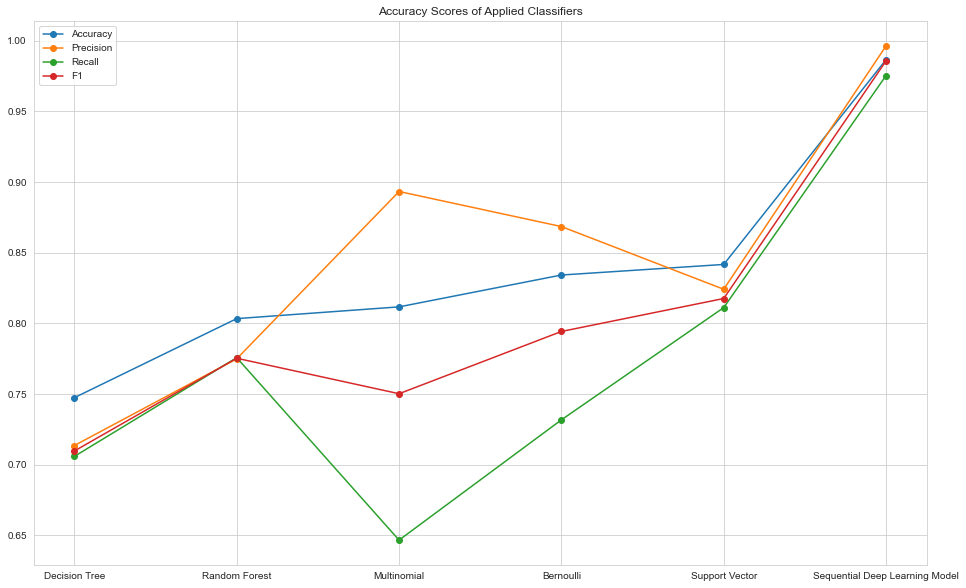

In [40]:
plt.figure(figsize=(16,10))
#plot 1:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_accuracy, r_accuracy, m_accuracy, b_accuracy, s_accuracy, accuracy])
plt.plot(x,y, marker = 'o', label='Accuracy')

#plot 2:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_precision, r_precision, m_precision, b_precision, s_precision, precision])
plt.plot(x,y, marker = 'o', label='Precision')

#plot 3:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_recall, r_recall, m_recall, b_recall, s_recall, recall])
plt.plot(x,y, marker = 'o', label='Recall')

#plot 4:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_f1, r_f1, m_f1, b_f1, s_f1, f1])
plt.plot(x,y, marker = 'o', label='F1')

plt.title("Accuracy Scores of Applied Classifiers")
plt.legend()
plt.show()